In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Repeat the calibration procedure that was done in Sections 7.3.1 and 7.3.2 using the
same optimizer for the following objective functions:

* sum of relative errors (SRE)
* sum of the absolute errors (SAE)
* sum of the squares of absolute errors (SSAE)

Compare the results, write down your findings and observations, and conclude on the
effect of the objective function on the results.

# 7.3.1


In [23]:
data1 = {
    "maturity" : [1, 2, 3, 6, 12], 
    "date_1": [3.1175, 3.2738, 3.4200, 3.4275, 3.4213], 
    "date_2": [0.2647, 0.2890, 0.3140, 0.4657, 0.7975]
}

data2 = {
    "term": [2, 3, 5, 7, 10, 15, 30],
    "date_1": [2.6967, 3.1557, 3.8111, 4.1497, 4.3638, 4.3753, 4.2772],
    "date_2": [1.0481, 1.5577, 2.5569, 3.1850, 3.7225, 4.1683, 4.4407]
}

In [24]:
df_libor = pd.DataFrame(data1)
df_swap = pd.DataFrame(data2)

# Define the close form solution for zero coupon bond prices

In [86]:
def P(A, B, r):
    return np.exp(A - B * r)

def B(t, T, k):
    return (1 - np.exp(-k * (T - t))) / k

def A(t, T, theta, k, sigma):
    first = (theta - sigma**2 / (2 * k**2))
    second = B(t, T, k) - (T - t)
    third = (sigma ** 2)/(4 * k) * B(t, T, k) ** 2

    return first * second - third

In [87]:
from scipy.optimize import minimize

In [165]:
def objective_function(params, data1, data2):
    k, theta, sigma, r0 = params
    errors = []

    # Iterate over LIBOR data to calculate errors
    for maturity, rate in zip(data1['maturity'], data1['date_1']):
        T = maturity / 12  # Convert months to years for maturity
        a = A(0, T, theta, k, sigma)
        b = B(0, T, k)
        bond_price = P(a, b, r0)
        libor_rate = 100 * ((1 / bond_price) - 1) / T  # Convert to annual rate
        market_yield = rate / 100
        ssre = ((libor_rate - market_yield) / market_yield) ** 2
        errors.append(ssre)

    # Iterate over swap data to calculate errors
    for term, rate in zip(data2['term'], data2['date_1']):
        T = term  # The term is already in years
        dt = 0.5  # Assuming payments every half-year
        n = int(term / dt)
        
        # Calculate bond price for swap's maturity
        a_T = A(0, T, theta, k, sigma)
        b_T = B(0, T, k)
        bond_price_T = P(a_T, b_T, r0)
        
        # Calculate the sum of the present value of cash flows
        sum_p = sum(P(A(0, i * dt, theta, k, sigma), B(0, i * dt, k), r0) for i in range(1, n+1))
        
        # Calculate the swap rate
        swap_rate = 100 * (1 - bond_price_T) / (dt * sum_p)
        
        # Compare to market swap rate
        market_yield = rate / 100
        ssre = ((swap_rate - market_yield) / market_yield) ** 2
        errors.append(ssre)

    # Return the sum of squared relative errors
    return sum(errors)

In [166]:
initial_guess = [0.1, 0.05, 0.1, 0.03]

In [167]:
result = minimize(objective_function, initial_guess, args=(data1, data2))

In [168]:
params1 = result.x
print("The parameters [kappa, theta, sigma, r0] are {}, {}, {}, {}".format(params1[0], params1[1], params1[2], params1[3]))

The parameters [kappa, theta, sigma, r0] are 0.14972198544325188, 0.0004923331007007624, 1.0761959088985052e-07, 0.0003108633120031689


# Use the second date to calibrate

In [128]:
def objective_function(params, data1, data2):
    k, theta, sigma, r0 = params
    errors = []

    # Iterate over LIBOR data to calculate errors
    for maturity, rate in zip(data1['maturity'], data1['date_2']):
        T = maturity / 12  # Convert months to years for maturity
        a = A(0, T, theta, k, sigma)
        b = B(0, T, k)
        bond_price = P(a, b, r0)
        libor_rate = 100 * ((1 / bond_price) - 1) / T  # Convert to annual rate
        market_yield = rate / 100
        ssre = ((libor_rate - market_yield) / market_yield) ** 2
        errors.append(ssre)

    # Iterate over swap data to calculate errors
    for term, rate in zip(data2['term'], data2['date_2']):
        T = term  # The term is already in years
        dt = 0.5  # Assuming payments every half-year
        n = int(term / dt)
        
        # Calculate bond price for swap's maturity
        a_T = A(0, T, theta, k, sigma)
        b_T = B(0, T, k)
        bond_price_T = P(a_T, b_T, r0)
        
        # Calculate the sum of the present value of cash flows
        sum_p = sum(P(A(0, i * dt, theta, k, sigma), B(0, i * dt, k), r0) for i in range(1, n+1))
        
        # Calculate the swap rate
        swap_rate = 100 * (1 - bond_price_T) / (dt * sum_p)
        
        # Compare to market swap rate
        market_yield = rate / 100
        ssre = ((swap_rate - market_yield) / market_yield) ** 2
        errors.append(ssre)

    # Return the sum of squared relative errors
    return sum(errors)

In [151]:
initial_guess = [0.3, 0.1, 0.1, 0.01]
result = minimize(objective_function, initial_guess, args=(data1, data2))
params = result.x
print("The parameters [kappa, theta, sigma, r0] are {}, {}, {}, {}".format(params[0], params[1], params[2], params[3]))

The parameters [kappa, theta, sigma, r0] are 0.2068376622883129, 0.0005782616825041548, 1.3552927899674663e-07, 1.9569006139952562e-05


In [294]:
k, theta, sigma, r0 = [0.1153, 0.0532, 0.0028, 0.0309]

def B(t, T, a):
    return (1 - np.exp(-a * (T - t))) / a

def A(t, T, b, a, sigma):
    B_value = B(t, T, a)
    return (b - (sigma**2) / (2 * a**2)) * (B_value - (T - t)) - (sigma**2) * B_value**2 / (4 * a)

def P(t, T, r_t, b, a, sigma):
    A_value = A(t, T, b, a, sigma)
    B_value = B(t, T, a)
    return np.exp(A_value - B_value * r_t)
    
# Simulation parameters
#k, theta, sigma, r0 = params1
T = 1
N = 30
dt = 1 / N
t = np.arange(0, T+dt/2, dt)
r = np.zeros_like(t)
a = np.zeros_like(t)
b = np.zeros_like(t)

r[0] = r0
for i in range(N):
    r[i+1] = r[i] + k * (theta - r[i]) * dt + sigma * np.sqrt(dt) * np.random.randn()

for i, time in enumerate(t)):
    b[i] = 

0.0
0.03333333333333333
0.06666666666666667
0.1
0.13333333333333333
0.16666666666666666
0.2
0.23333333333333334
0.26666666666666666
0.3
0.3333333333333333
0.36666666666666664
0.4
0.43333333333333335
0.4666666666666667
0.5
0.5333333333333333
0.5666666666666667
0.6
0.6333333333333333
0.6666666666666666
0.7
0.7333333333333333
0.7666666666666666
0.8
0.8333333333333334
0.8666666666666667
0.9
0.9333333333333333
0.9666666666666667
1.0


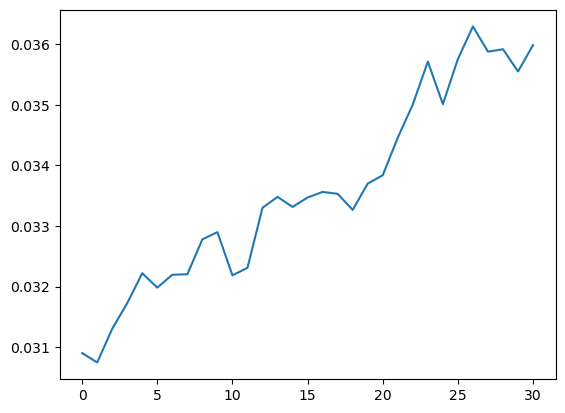

In [292]:
plt.plot(r)